# Introduction to Recommender Systems

<p align="center">
    <img width="721" alt="cover-image" src="https://user-images.githubusercontent.com/49638680/204351915-373011d3-75ac-4e21-a6df-99cd1c552f2c.png">
</p>

---

# Non-Personalised Recommendations

Let's introduce a non-personalised recommendation system. Before proceeding let's point out the reasons for the non-personalised recommendations:

1. New users: we know little about them (_cold-start_ problem).
2. Simple implementation but beneficial.
3. Communities share the same behaviour, hence same recommendations.
4. Applications to cases where personalised recommendations are impossible.

As an example, think about the weekly review of books or restaurants on newspaper articles.
These are also called __stereotyped recommender system__.

## A code implementation of a non-personalised recommendation system

The aim of this notebook is to provide an implementation of a non-personalised recommendation system.


In [1]:
# Import libraries
import numpy as np
import pandas as pd
from typing import List
from scipy.sparse import csr_matrix

from utils import non_pers_rec as npr
from utils.data_utils import load_data
from tests.non_pers_tests import test_get_recent_liked_movie, test_get_movie_genre

import matplotlib.pyplot as plt
import seaborn as sns

# set plot size
plt.rcParams["figure.figsize"] = (20, 13)
sns.set()
%matplotlib inline
%config InlineBackend.figure_format = "retina"

We are going to use only numpy to build the recommender for users that have not rated any movie, by suggesting the most popular movie in the catalogue.

### Import data

The data comes from the famous [movielens dataset](https://grouplens.org/datasets/movielens/), here we import the data into dataframes in order to make a nice data analysis before digging into the model.

In [2]:
%%bash
if [ ! -d "../data/movielens_complete" ]; 
then    
    wget http://files.grouplens.org/datasets/movielens/ml-latest.zip
    mkdir -p ../data/movielens_complete
    unzip -o ml-latest.zip -d ../data/movielens_complete;
else
    echo "Data already downloaded";
fi

Data already downloaded


Let's now import such big data structures into dataframes.

**Careful!** This can take some time.

In [2]:
df_rating = pd.read_csv(
    "../data/movielens_complete/ml-latest/ratings.csv",
    engine="python",
)
df_rating.columns = ["UserId", "MovieId", "Rating", "Timestamp"]
df_rating_test = pd.read_csv(
    "http://files.grouplens.org/datasets/movielens/ml-100k/u1.test",
    sep="\t",
    engine="python",
    header=None,
)

df_users = pd.read_csv(
    "http://files.grouplens.org/datasets/movielens/ml-100k/u.user",
    sep="|",
    engine="python",
    header=None,
)
df_users.columns = ["UserId", "Age", "Gender", "Occupation", "ZipCode"]
df_users.set_index("UserId", inplace=True)
df_items = pd.read_csv(
    "../data/movielens_complete/ml-latest/movies.csv",
    engine="python",
    encoding="ISO-8859-1",
)
df_items.set_index("movieId", inplace=True)

In [3]:
df_rating.head()

,UserId,MovieId,Rating,Timestamp
0,1,307,3.5,1256677221
1,1,481,3.5,1256677456
2,1,1091,1.5,1256677471
3,1,1257,4.5,1256677460
4,1,1449,4.5,1256677264


In [6]:
df_rating.info(
    memory_usage="deep"
)  # memory_usage parameter allows us to see the real memory usage

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27753445 entries, 0 to 27753444
Data columns (total 4 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   UserId     object
 1   MovieId    object
 2   Rating     object
 3   Timestamp  object
dtypes: object(4)
memory usage: 6.5 GB


We can see that the dataframe is simply too large to be handled properly. 
There is a variety of possible solutions to face such an issue.

Here, we do something really simple: we will use a reduced version of the dataset, available at the same url as above.

A custom function does the import of the dataset into pandas objects for you.

In [4]:
# Import data from movielens dataset

df_rating, df_rating_test, df_users, df_items, df_matrix, n_users, n_items = load_data()

In order to compose the training data as we have seen in lectures, we need to create a matrix having users in rows and movies in columns (or its equivalent transpose matrix).

This can be easily done by a pivot operator in pandas.

In [5]:
df_rating.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   UserId     80000 non-null  int64
 1   MovieId    80000 non-null  int64
 2   Rating     80000 non-null  int64
 3   Timestamp  80000 non-null  int64
dtypes: int64(4)
memory usage: 2.4 MB


In [6]:
df_matrix = df_rating.pivot(index="UserId", columns="MovieId", values="Rating")

n_users = len(df_users)
n_items = len(df_items)

In [5]:
df_matrix

MovieId,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
UserId,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,NaN,4.0,1.0,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
940,NaN,NaN,NaN,2.0,NaN,NaN,4.0,5.0,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
941,5.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


As one can see, the matrix is full of nan values.

## Exploratory data analysis

Let's have a look at the data, just to get some insights that will help us in the rest of the course.

### Rating distribution

First of all, we want to study the distributions of all ratings. This is useful to see whether in our database we have a particularly unbalanced rating, or if on average all movies are equally appreciated.

There are several ways to do so, all enlightening a slightly different aspect of the data. 
Recall that the rating matrix is _sparse_ (_i.e._ plenty of nan's).

Consider the following,

1. **Histograms**: You can plot a histogram of the non-zero values in your sparse matrix to see their distribution.

2. **Density plots**: Another way to visualize the distribution of values in a sparse matrix is to plot a density plot, which is a smoothed version of a histogram.

3. **Box plots**: A box plot can give you a good idea of the distribution of values in your sparse matrix, especially if you have a large number of non-zero values.

4. **Scatter plots**: You can also plot the non-zero values in your sparse matrix as a scatter plot, which can give you an idea of the distribution and relationship between different values.

Let's look at the density plot (we leave the other plots as exercise).

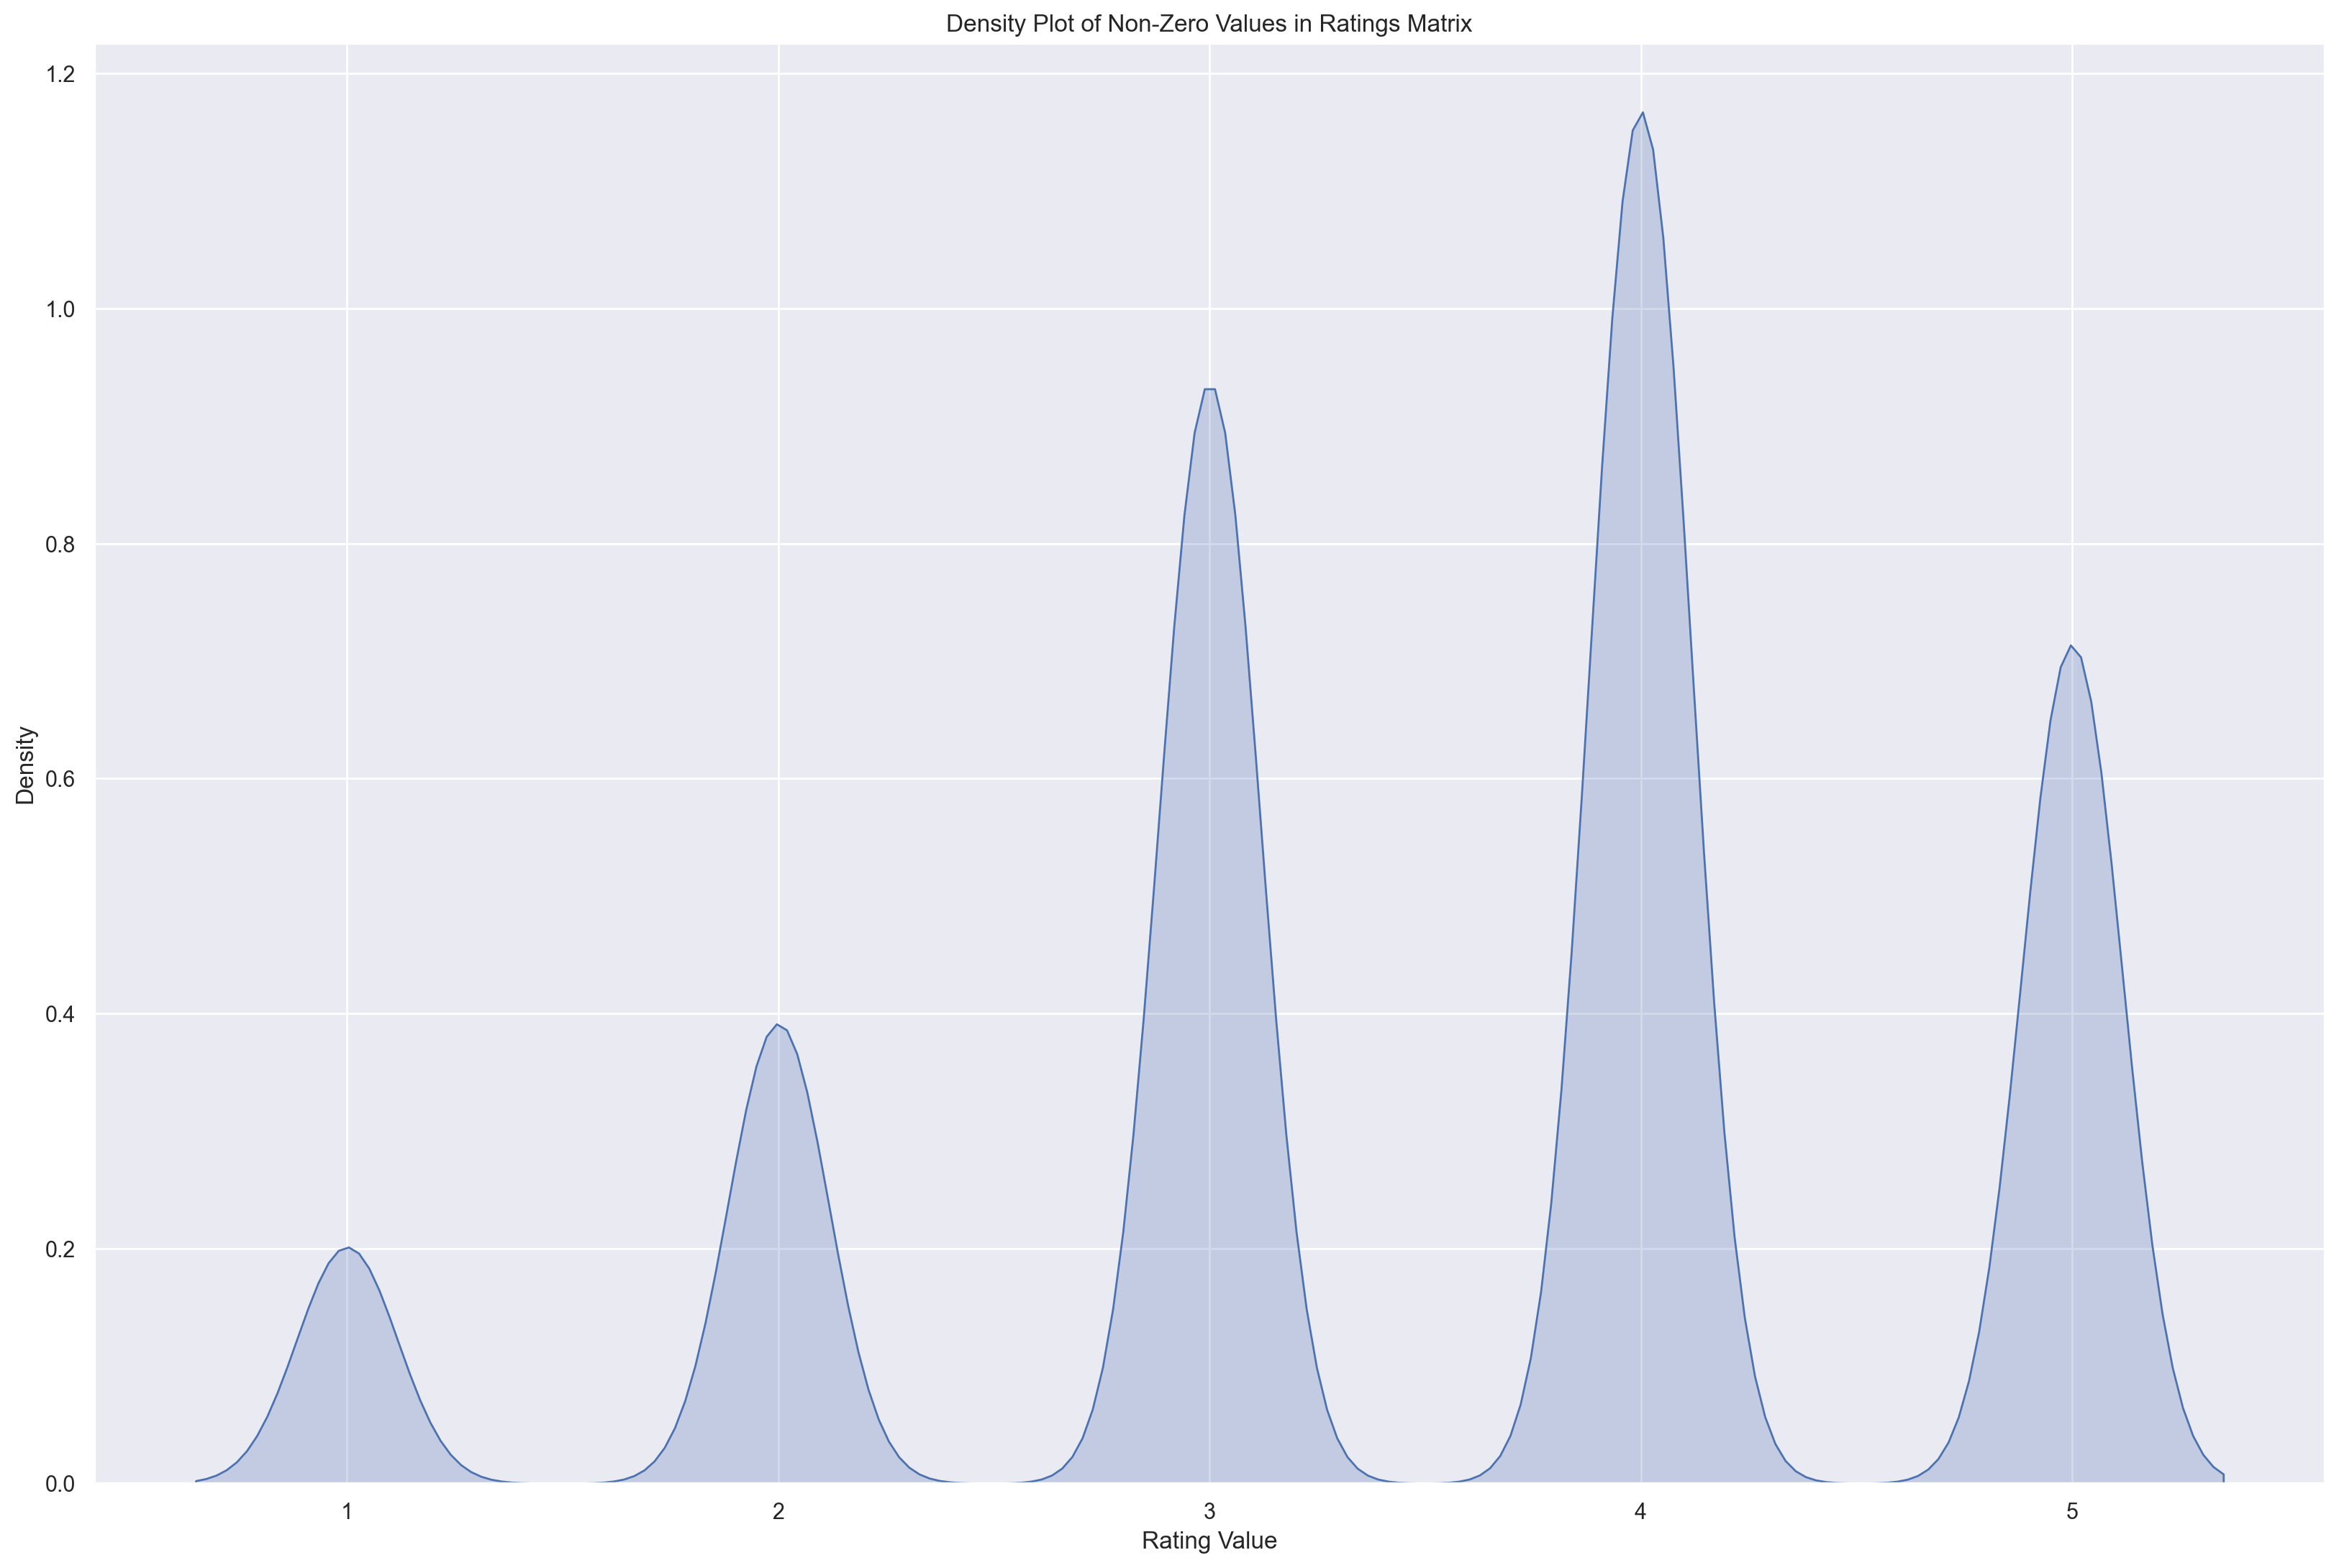

In [9]:
non_zero_values = csr_matrix(df_matrix.T.fillna(0).values)

# Plot the density plot of the non-zero values
sns.kdeplot(non_zero_values.data, shade=True)

# Add a title and labels to the plot
plt.title("Density Plot of Non-Zero Values in Ratings Matrix")
plt.xlabel("Rating Value")
plt.ylabel("Density")

# Show the plot
plt.show()

### Rating frequency

#### Rating frequency per movie

Another interesting feature to study is the rating frequency of movies. 
Indeed, we are interested in understanding whether people are always rating the same movies (_i.e._ the popular ones) or if the rating distribution is evenly distributed across all movies.

This can be determined by looking at the count of rating per movie.

In [7]:
movie_rat_freq = pd.DataFrame(df_rating.groupby("MovieId").size(), columns=["count"])
movie_rat_freq.head()

,count
MovieId,
1,383
2,105
3,75
4,171
5,69


We are ready to plot the rating frequency per movie.

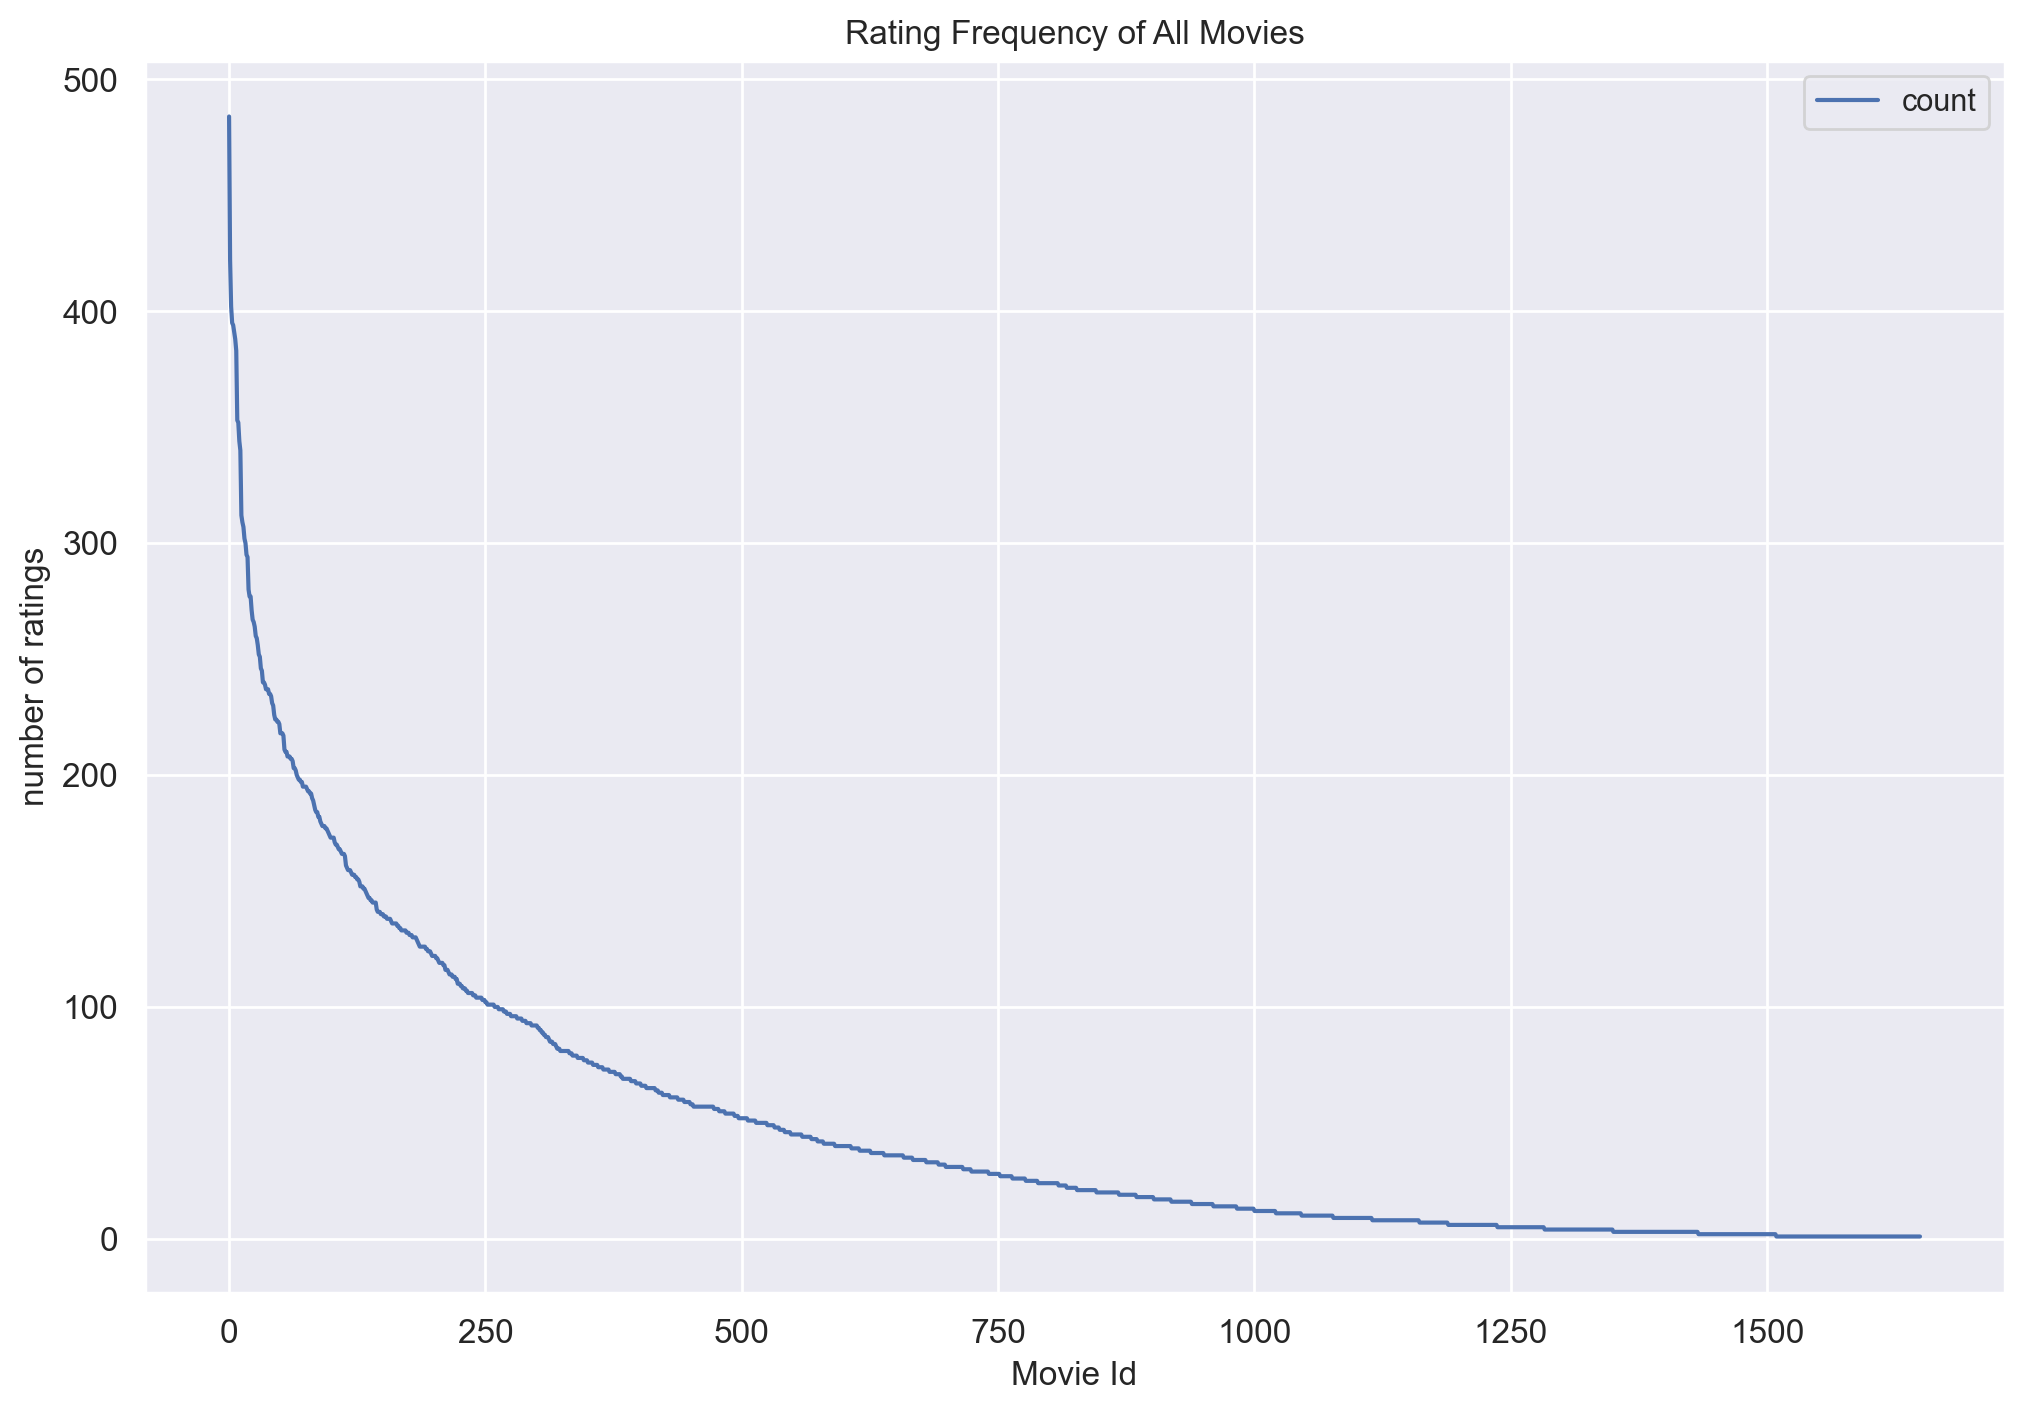

In [18]:
# plot rating frequency of all movies
ax = (
    movie_rat_freq.sort_values("count", ascending=False)
    .reset_index(drop=True)
    .plot(figsize=(12, 8), title="Rating Frequency of All Movies", fontsize=12)
)
ax.set_xlabel("Movie Id")
ax.set_ylabel("number of ratings");

The distribution of ratings among movies often satisfies a property in real-world settings, which is referred to as the _long-tail property_. According to this property, only a small fraction of the items are rated frequently. Such items are referred to as popular items. The vast majority of items are rated rarely. This results in a highly skewed distribution of the underlying ratings.

Let's plot the same distribution but with log scale.

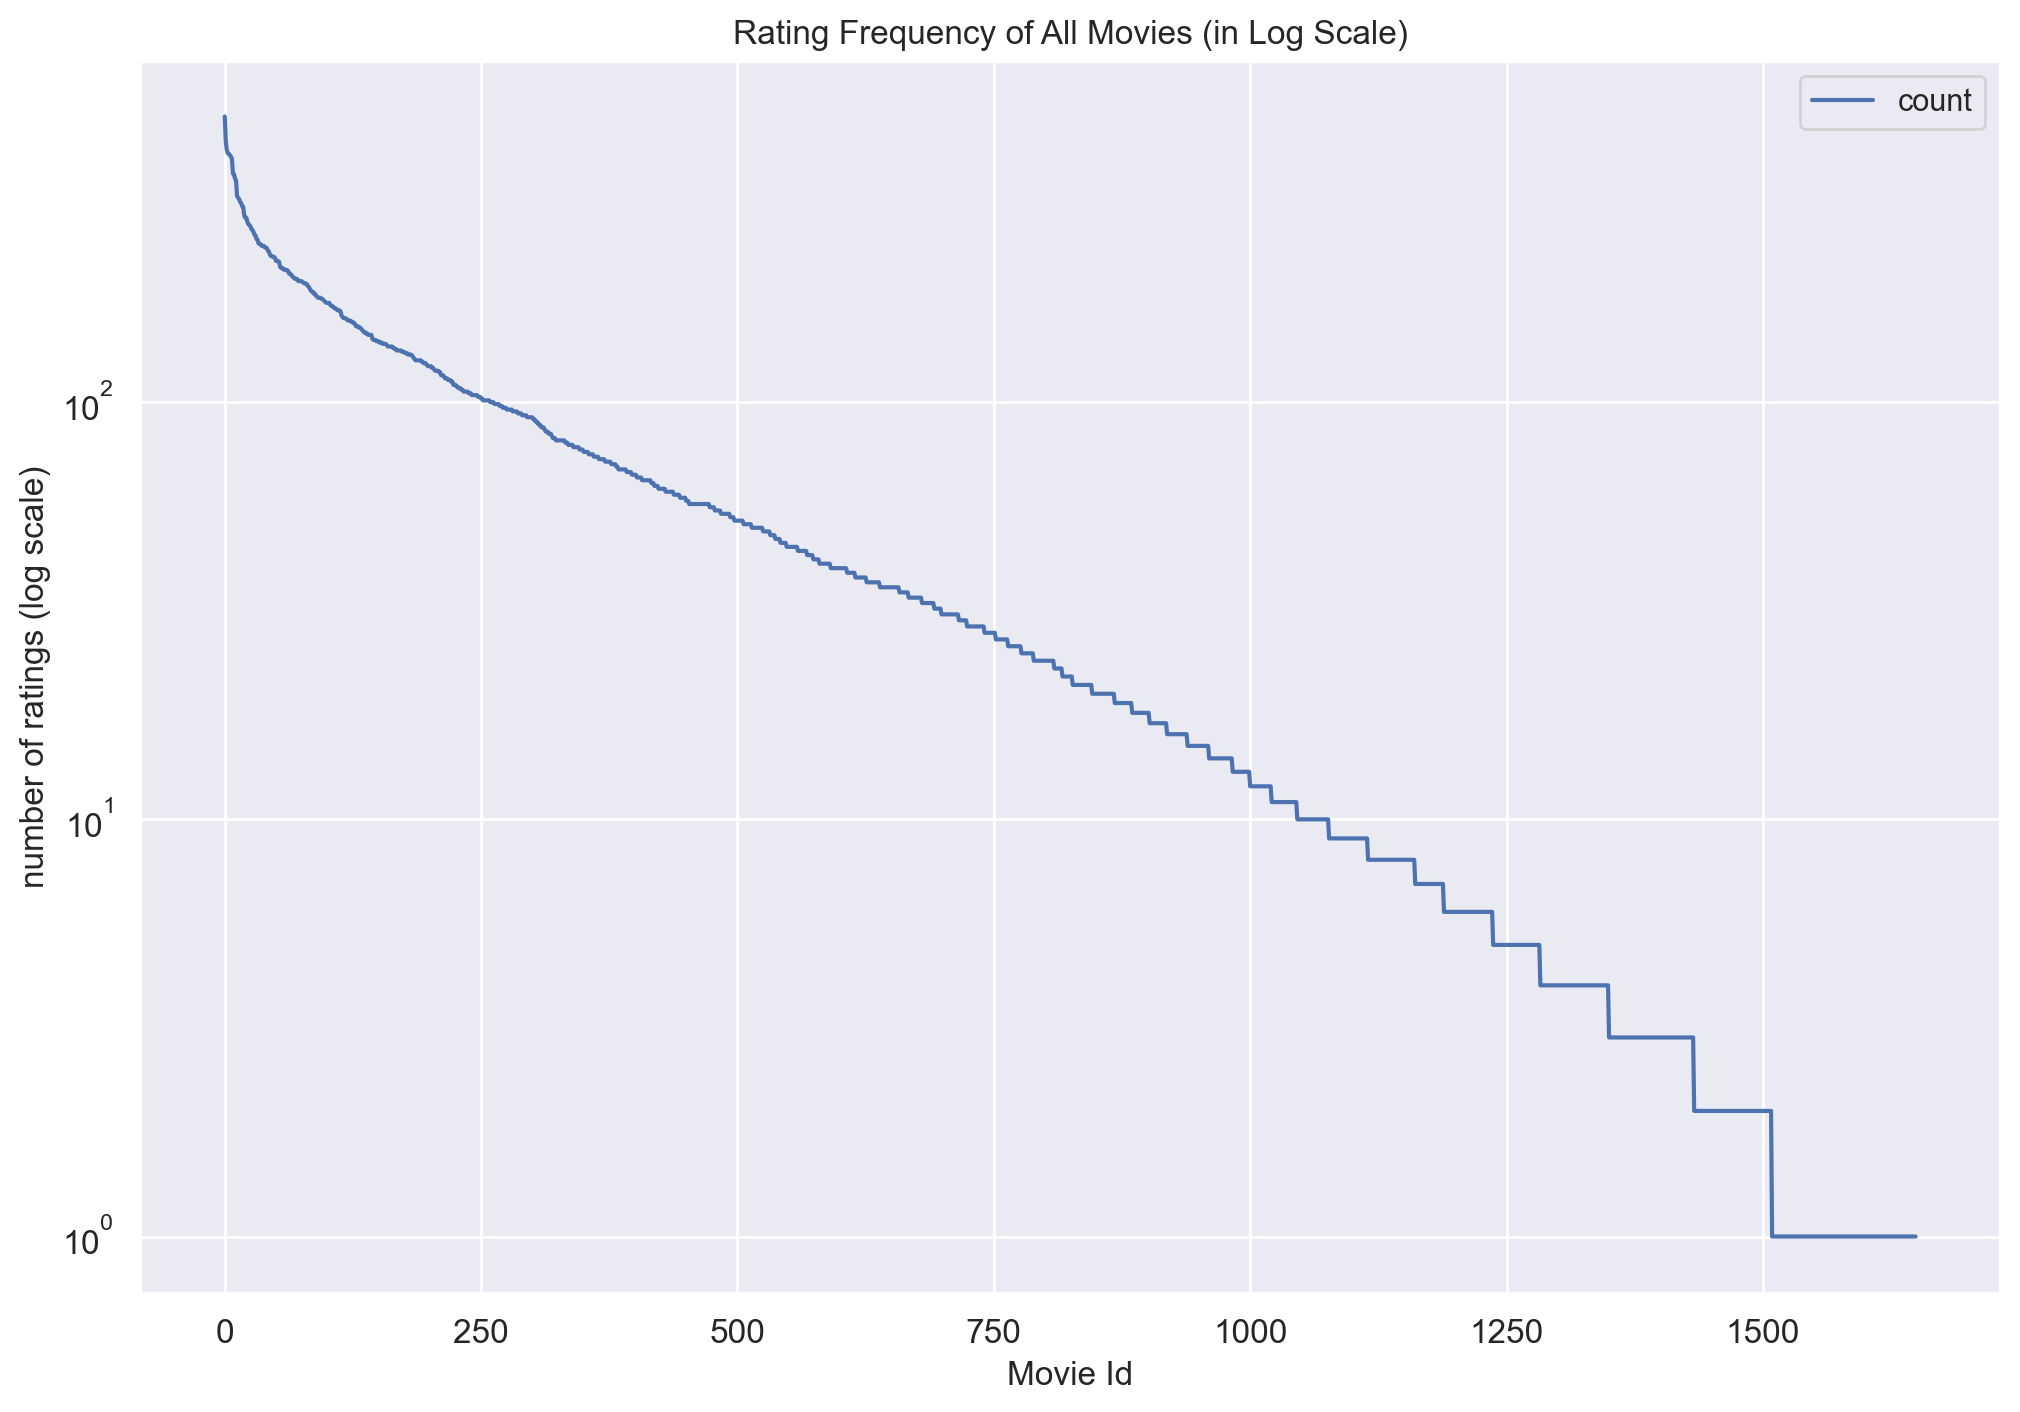

In [20]:
# plot rating frequency of all movies in log scale
ax = (
    movie_rat_freq.sort_values("count", ascending=False)
    .reset_index(drop=True)
    .plot(
        figsize=(12, 8),
        title="Rating Frequency of All Movies (in Log Scale)",
        fontsize=12,
        logy=True,
    )
)
ax.set_xlabel("Movie Id")
ax.set_ylabel("number of ratings (log scale)");

We can see that ~$700$ movies out of $1682$ are rated less than only $10$ times. Let's look closer by displaying top quantiles of rating counts.

In [23]:
movie_rat_freq["count"].quantile(np.arange(1, 0.6, -0.05))

1.00    484.0
0.95    188.1
0.90    135.0
0.85    103.0
0.80     81.0
0.75     65.0
0.70     53.0
0.65     42.0
Name: count, dtype: float64

So about $1\%$ of movies have roughly $484$ or more ratings, $5\%$ have $188$ or more, and $20\%$ have $80$ or more. 

This is an effect of the reduced dataset we have chosen.

Try to import the complete dataset from [movielens](https://grouplens.org/datasets/movielens/) and repeat this very same analysis. 

You will find an even longer tail effect, which leads to the choice of the reduced dataset.

This is convenient for a two-fold reason:

1. Memory issue: we don't want to run into the “MemoryError” during model training
2. Improve model performance: lesser known movies have ratings from fewer viewers, making the pattern more noisy. Dropping out less known movies can improve recommendation quality.

#### Rating frequency per user

At this stage, it is useful to study the rating frequency per user.

In [25]:
user_rat_freq = pd.DataFrame(df_rating.groupby("UserId").size(), columns=["count"])
user_rat_freq.head()

,count
UserId,
1,135
2,40
3,28
4,14
5,91


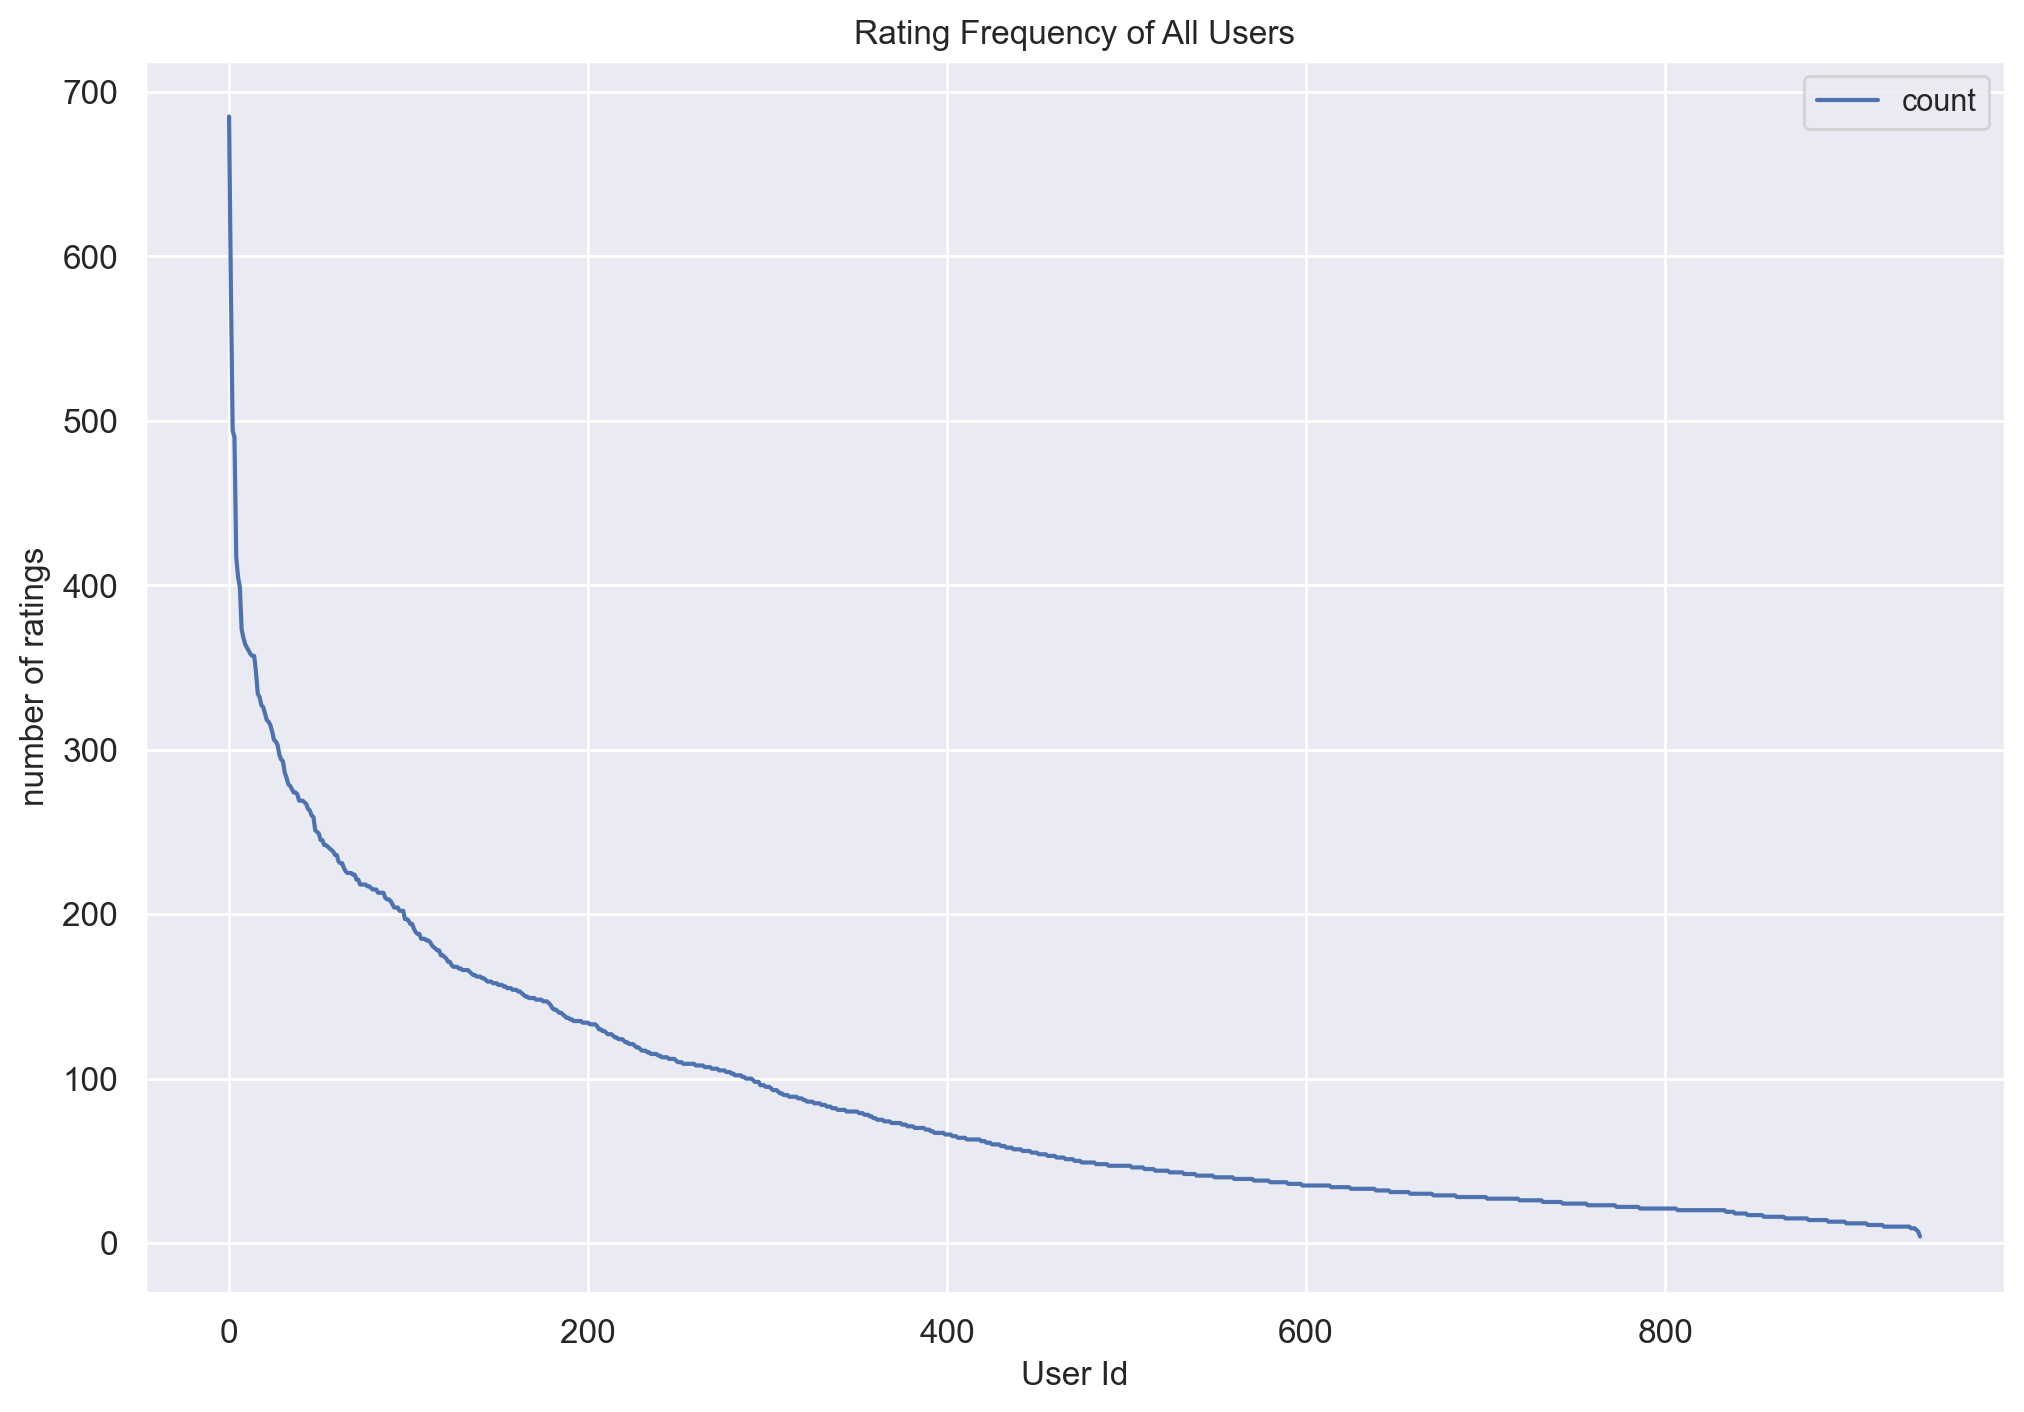

In [27]:
# plot rating frequency of all users
ax = (
    user_rat_freq.sort_values("count", ascending=False)
    .reset_index(drop=True)
    .plot(figsize=(12, 8), title="Rating Frequency of All Users", fontsize=12)
)
ax.set_xlabel("User Id")
ax.set_ylabel("number of ratings");

We can see that the distribution of ratings by users is very similar to the distribution of ratings among movies.
Again, we can see the long-tail effect, less pronounced than in the movie distribution, but still there.

This means that few users give a lot of feedbacks on movies they see (they are called "engaged users"). Indeed, only a very small fraction of users are very actively engaged with rating movies that they watched. Vast majority of users are not interested in rating movies.

In [28]:
user_rat_freq["count"].quantile(np.arange(1, 0.5, -0.05))

1.00    685.0
0.95    258.2
0.90    203.6
0.85    161.0
0.80    137.0
0.75    115.0
0.70    102.0
0.65     84.3
0.60     72.0
0.55     61.0
Name: count, dtype: float64

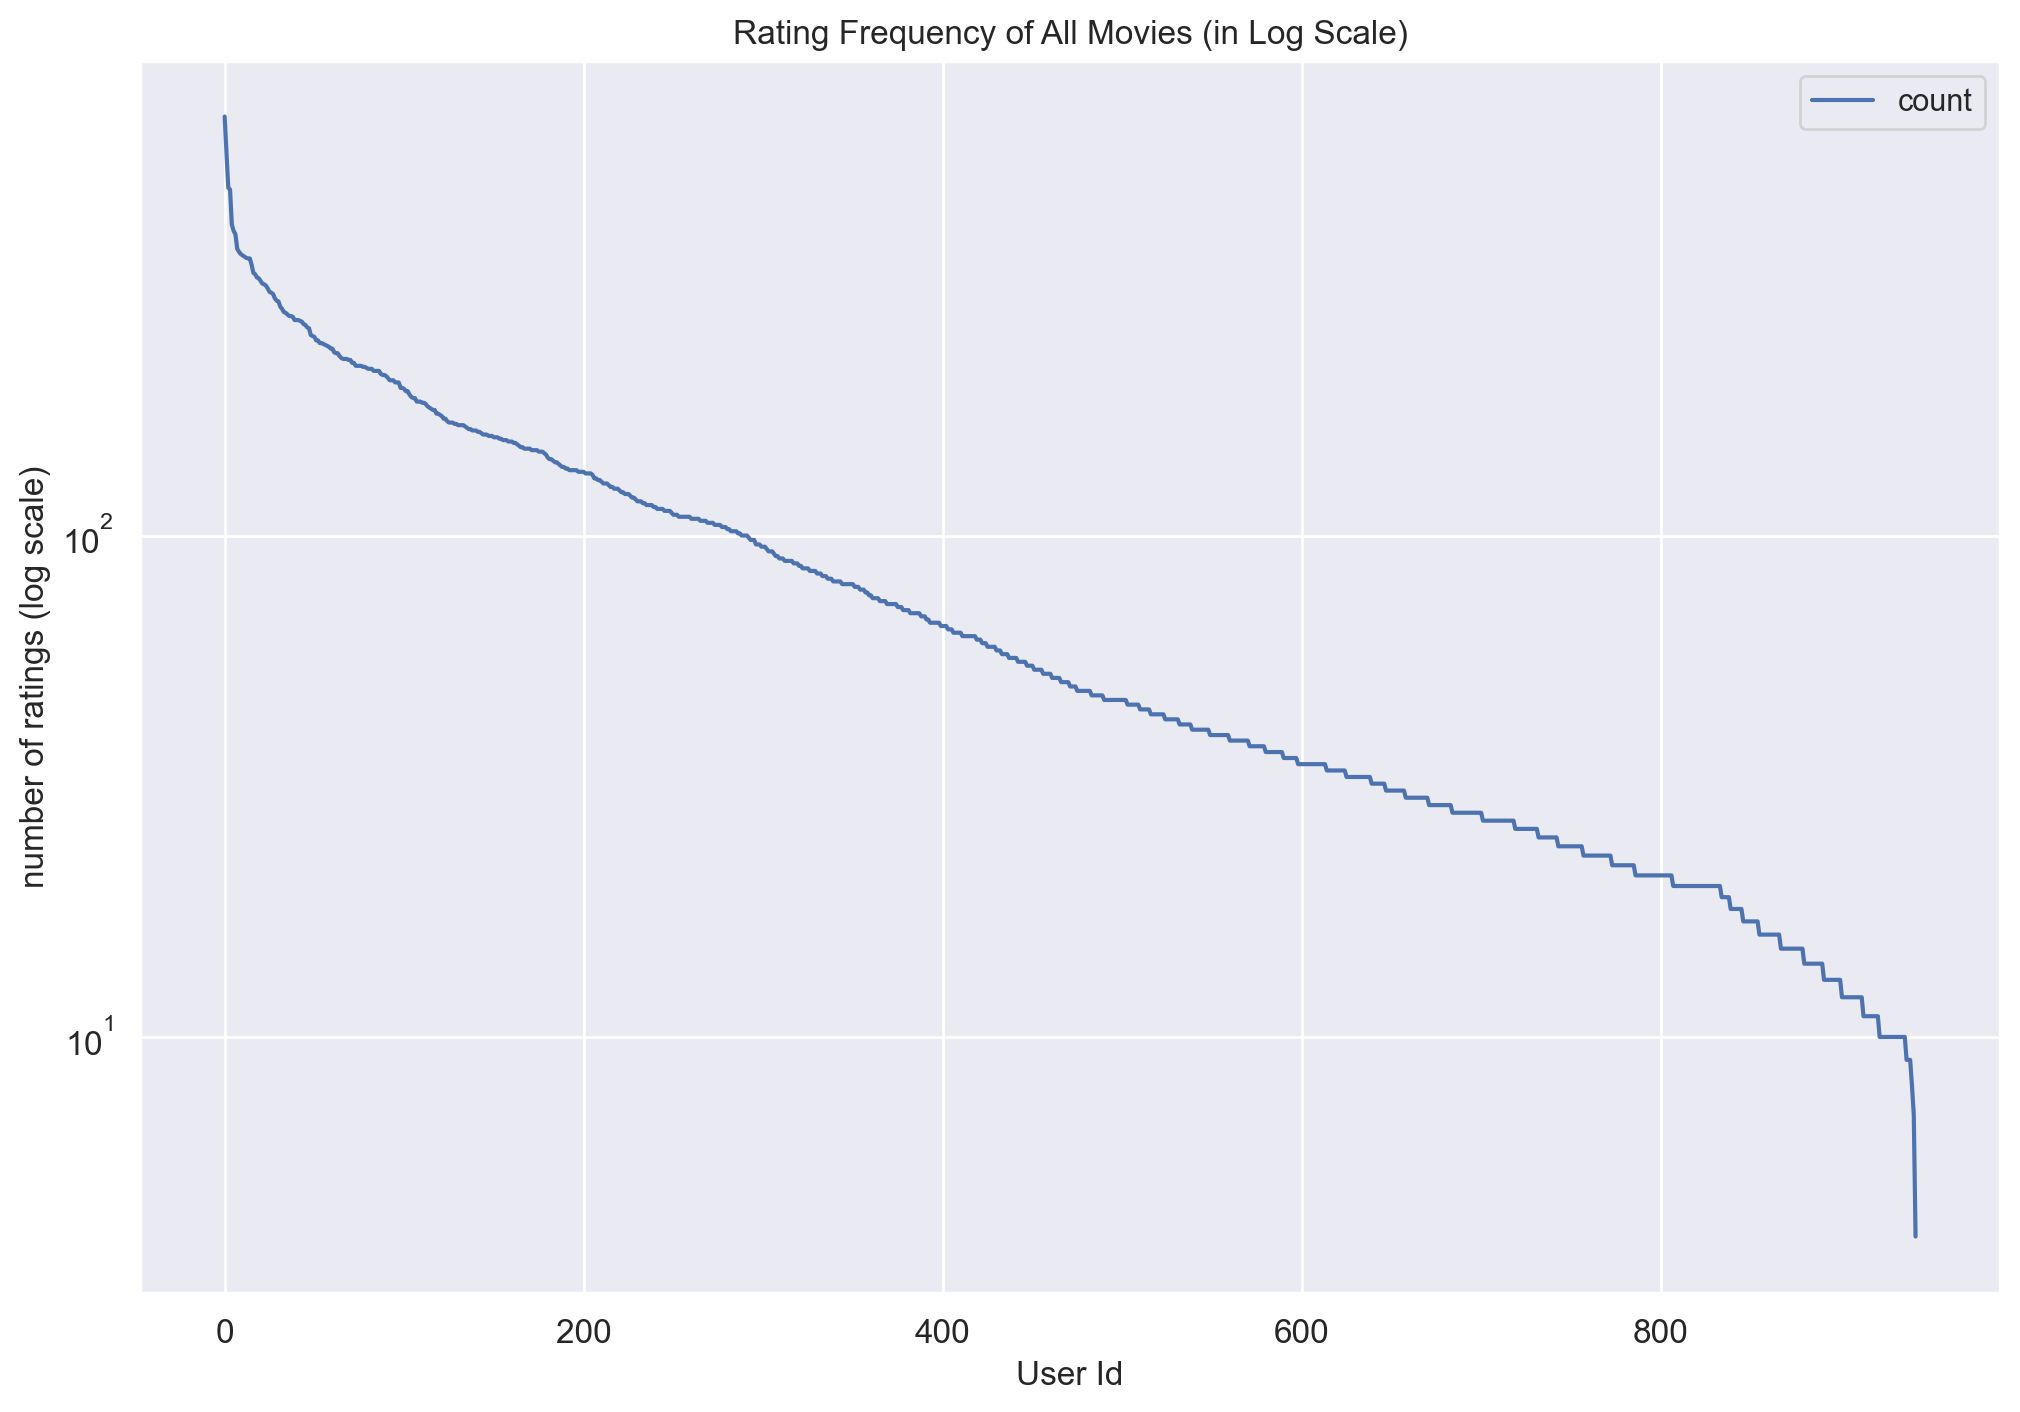

In [29]:
# plot rating frequency of all users in log scale
ax = (
    user_rat_freq.sort_values("count", ascending=False)
    .reset_index(drop=True)
    .plot(
        figsize=(12, 8),
        title="Rating Frequency of All Movies (in Log Scale)",
        fontsize=12,
        logy=True,
    )
)
ax.set_xlabel("User Id")
ax.set_ylabel("number of ratings (log scale)");

#### Exercise

Repeat the very same analysis for the bigger version of the movielens dataset, the one that can be downloaded at [http://files.grouplens.org/datasets/movielens/ml-10m.zip](http://files.grouplens.org/datasets/movielens/ml-10m.zip).

Show that the long-tail effect is much more evident.

### Calculate the most popular movie

Let's look at the movie colums. We can create a vector, summing over the colums, to get a _total score_ measuring how much that movie has been rated.

Thanks to pandas methods, this can be done by one line of code.

In [6]:
movie_scores = df_matrix.sum(axis=0, skipna=True)
movie_scores

MovieId
1       1491.0
2        334.0
3        225.0
4        603.0
5        228.0
         ...  
1678       1.0
1679       3.0
1680       2.0
1681       3.0
1682       3.0
Length: 1650, dtype: float64

Now we need to store the movie score in the corresponding dataframe.
Since the movie score is a pandas series, whose index is the same as the index of the movie dataframe, we can simply add a column as follows.

In [7]:
df_items["score"] = movie_scores
df_items

,Title,Date,VideoReleaseDate,Url,unknown,Action,Adventure,Animation,Children,Comedy,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,score
MovieId,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,1491.0
2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,...,0,0,0,0,0,0,1,0,0,334.0
3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,225.0
4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,603.0
5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,228.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1678,Mat' i syn (1997),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?Mat%27+i+syn+...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
1679,B. Monkey (1998),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?B%2E+Monkey+(...,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,3.0
1680,Sliding Doors (1998),01-Jan-1998,NaN,http://us.imdb.com/Title?Sliding+Doors+(1998),0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,2.0


### Giving recommendations

Hence, we are ready to give recommendations. 

We split the problem into four steps of growing difficulty.

1. We always recommend the most popular movie.
2. We recommend the most popular movie in the same genre of the best rated movie per each user.
3. We look at the last rated movie (whose rating is over 4) for each user and we recommend the most popular movie in the same genre.
4. We do as in $3.$ but with a random distribution, we pick uniformly amongst the first $10$ most popular movies.

#### Most popular movie recommendation

The first point is the easiest one, we only need to look at the movie whose score is the highest one.

In [8]:
df_items.iloc[[df_items.score.argmax()]]

,Title,Date,VideoReleaseDate,Url,unknown,Action,Adventure,Animation,Children,Comedy,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,score
MovieId,,,,,,,,,,,,,,,,,,,,,
50,Star Wars (1977),01-Jan-1977,NaN,http://us.imdb.com/M/title-exact?Star%20Wars%2...,0,1,1,0,0,0,...,0,0,0,0,1,1,0,1,0,2110.0


Hence, let's write a recommendation function.

In [9]:
def recommend_one():
    """Function to return the recommendations based on the most popular criterion."""
    return df_items.loc[[df_items.score.argmax() + 1]]

In [10]:
recommend_one()

,Title,Date,VideoReleaseDate,Url,unknown,Action,Adventure,Animation,Children,Comedy,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,score
MovieId,,,,,,,,,,,,,,,,,,,,,
50,Star Wars (1977),01-Jan-1977,NaN,http://us.imdb.com/M/title-exact?Star%20Wars%2...,0,1,1,0,0,0,...,0,0,0,0,1,1,0,1,0,2110.0


This function returns just the most popular movie. However, we may want to consider multiple recommendations: hence we want to return the first then movies with the highest popularity score.

In [11]:
def recommend_n(n_recommendations: int = 10) -> pd.DataFrame:
    """Function to return recommendations based on the most popular criterion.
    Parameters
    ----------
    n_recommendations: int
        Number of recommendations to return.
        default: 10

    Returns
    -------
    pd.DataFrame
        The dataframe containing the recommendations in order of preference.
    """
    return df_items.sort_values(by="score", ascending=False).iloc[:n_recommendations]

In [12]:
recommend_n()

,Title,Date,VideoReleaseDate,Url,unknown,Action,Adventure,Animation,Children,Comedy,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,score
MovieId,,,,,,,,,,,,,,,,,,,,,
50,Star Wars (1977),01-Jan-1977,NaN,http://us.imdb.com/M/title-exact?Star%20Wars%2...,0,1,1,0,0,0,...,0,0,0,0,1,1,0,1,0,2110.0
181,Return of the Jedi (1983),14-Mar-1997,NaN,http://us.imdb.com/M/title-exact?Return%20of%2...,0,1,1,0,0,0,...,0,0,0,0,1,1,0,1,0,1693.0
100,Fargo (1996),14-Feb-1997,NaN,http://us.imdb.com/M/title-exact?Fargo%20(1996),0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1623.0
258,Contact (1997),11-Jul-1997,NaN,http://us.imdb.com/Title?Contact+(1997/I),0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1537.0
1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,1491.0
174,Raiders of the Lost Ark (1981),01-Jan-1981,NaN,http://us.imdb.com/M/title-exact?Raiders%20of%...,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1461.0
127,"Godfather, The (1972)",01-Jan-1972,NaN,"http://us.imdb.com/M/title-exact?Godfather,%20...",0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1448.0
286,"English Patient, The (1996)",15-Nov-1996,NaN,http://us.imdb.com/M/title-exact?English%20Pat...,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,1413.0
288,Scream (1996),20-Dec-1996,NaN,http://us.imdb.com/M/title-exact?Scream%20(1996),0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,1347.0


#### Most popular movie in the same genre recommendation

Now we start to include the user history in some sense. This is not personalised, as we never use user features, but we focus on the last movie the user liked in order to make a recommendation about a new movie.

This is a first example of _content based recommendations_.

First, we need to see which movie the user liked most recently. This can be done by looking at the "timestamp" column in rating table.

<details>
    <summary><b>HINT</b></summary> 
    
    You can find the implemented function in the utils module `non_pers_rec.py`. 
    Try to implement the function on your own before looking at the given implementation.
</details>

In [13]:
def get_recent_liked_movie(user_id: int, threshold: float = 4.0) -> int:
    """Function to get the id of the movie that the user has liked most recently.

    Parameters
    ----------
    user_id : int
        The id of the user we are interested in.
    threshold : float
        The rating threshold, to determine whether a user appreciated the movie.
        default: 4.0

    Returns
    -------
    int
        The movie id that the user has liked most recently.
    """
    # Complete the function

In [13]:
### Unit tests ###
test_get_recent_liked_movie(get_recent_liked_movie)

 All tests passed.


##### Extract the genre information

The idea is to use the just-found id, to extract the genre information out of the `df_items` dataframe, and then recommend the most popular movies in the same genre.

**Note**: The `df_items` dataframe is multi-hot encoding the genre information, hence a movie can have multiple genres and they are stored as ones in the corresponding columns of the dataframe.

To fix this issue, we define a pandas series populated converting the multi-hot encoding columns into a single column.

In [13]:
genre_cols = [
    "Action",
    "Adventure",
    "Animation",
    "Children",
    "Comedy",
    "Crime",
    "Documentary",
    "Drama",
    "Fantasy",
    "Film-Noir",
    "Horror",
    "Musical",
    "Mystery",
    "Romance",
    "Sci-Fi",
    "Thriller",
    "War",
    "Western",
]


genre_series = df_items[genre_cols].apply(
    lambda row: row[row == 1].index.tolist(), axis=1
)
genre_series

MovieId
1       [Animation, Children, Comedy]
2       [Action, Adventure, Thriller]
3                          [Thriller]
4             [Action, Comedy, Drama]
5            [Crime, Drama, Thriller]
                    ...              
1678                          [Drama]
1679              [Romance, Thriller]
1680                 [Drama, Romance]
1681                         [Comedy]
1682                          [Drama]
Length: 1682, dtype: object

Once the list of genres has been used to create the corresponding column, we can extract such information passing the movie id.

In [14]:
def get_genre(movie_id: int) -> List[str]:
    """Function to get the genre of the inserted movie.

    Parameters
    ----------
    movie_id : int
        The id of the movie whose genre is to be returned.

    Returns
    -------
    list of str
        the genres of the inserted movie.
    """

    # Complete the function

In [15]:
### Unit tests ###
test_get_movie_genre(get_genre)

 All tests passed.


At this stage, we need to make a choice. 
In particular, we have to decide how to handle the case where one movie is classified in more than one genre.

Our choice is the following:
> If a movie has more than one genre, then we take the most popular movies in all the genres appearing in the list.

Let's write a code to recommend the first $n$ movies in the genre of the last positively evaluated movie.

In [23]:
def recommend_genre_n(
    n_recommendations: int = 10, genres: List[str] = None
) -> pd.DataFrame:
    """Function to return recommendations based on the most popular criterion in a given genre list.
    Parameters
    ----------
    n_recommendations: int
        Number of recommendations to return.
        default: 10
    genres: List of strings
        The list of genres in which to return the recommendations.
        If not provided, the function will return the recommendations based on all genres.
        default: None

    Returns
    -------
    pd.DataFrame
        The dataframe containing the recommendations in order of preference.
    """

    if genres is not None:
        # Filter movies by genre
        mask = df_items[genres].eq(1).all(axis=1)
        return (
            df_items[mask]
            .sort_values(by="score", ascending=False)
            .iloc[:n_recommendations]
        )
    else:
        return recommend_n(n_recommendations=n_recommendations)

Let's make sure that the function works as expected.

In [25]:
# Call on all the genres.
recommend_genre_n()

,Title,Date,VideoReleaseDate,Url,unknown,Action,Adventure,Animation,Children,Comedy,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,score
MovieId,,,,,,,,,,,,,,,,,,,,,
50,Star Wars (1977),01-Jan-1977,NaN,http://us.imdb.com/M/title-exact?Star%20Wars%2...,0,1,1,0,0,0,...,0,0,0,0,1,1,0,1,0,2110.0
181,Return of the Jedi (1983),14-Mar-1997,NaN,http://us.imdb.com/M/title-exact?Return%20of%2...,0,1,1,0,0,0,...,0,0,0,0,1,1,0,1,0,1693.0
100,Fargo (1996),14-Feb-1997,NaN,http://us.imdb.com/M/title-exact?Fargo%20(1996),0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1623.0
258,Contact (1997),11-Jul-1997,NaN,http://us.imdb.com/Title?Contact+(1997/I),0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1537.0
1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,1491.0
174,Raiders of the Lost Ark (1981),01-Jan-1981,NaN,http://us.imdb.com/M/title-exact?Raiders%20of%...,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1461.0
127,"Godfather, The (1972)",01-Jan-1972,NaN,"http://us.imdb.com/M/title-exact?Godfather,%20...",0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1448.0
286,"English Patient, The (1996)",15-Nov-1996,NaN,http://us.imdb.com/M/title-exact?English%20Pat...,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,1413.0
288,Scream (1996),20-Dec-1996,NaN,http://us.imdb.com/M/title-exact?Scream%20(1996),0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,1347.0


In [26]:
genres = ["Crime", "Drama"]

recommend_genre_n(genres=genres)

,Title,Date,VideoReleaseDate,Url,unknown,Action,Adventure,Animation,Children,Comedy,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,score
MovieId,,,,,,,,,,,,,,,,,,,,,
100,Fargo (1996),14-Feb-1997,NaN,http://us.imdb.com/M/title-exact?Fargo%20(1996),0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1623.0
127,"Godfather, The (1972)",01-Jan-1972,NaN,"http://us.imdb.com/M/title-exact?Godfather,%20...",0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1448.0
56,Pulp Fiction (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Pulp%20Fictio...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1252.0
187,"Godfather: Part II, The (1974)",01-Jan-1974,NaN,http://us.imdb.com/M/title-exact?Godfather:%20...,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,736.0
182,GoodFellas (1990),01-Jan-1990,NaN,http://us.imdb.com/M/title-exact?GoodFellas%20...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,698.0
403,Batman (1989),01-Jan-1989,NaN,http://us.imdb.com/M/title-exact?Batman%20(1989),0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,553.0
293,Donnie Brasco (1997),28-Feb-1997,NaN,http://us.imdb.com/M/title-exact?Donnie%20Bras...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,494.0
327,Cop Land (1997),01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Cop+Land+(1997),0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,469.0
628,Sleepers (1996),18-Oct-1996,NaN,http://us.imdb.com/M/title-exact?Sleepers%20(1...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,466.0


**Excercise** 

What is missing at this stage is a function combining the work we have done above such that given a user id, we can have recommendations based on what the user liked more recently. 
_Writing such a function is left as an exercise._

Be sure to handle the case of a new user, _e.g._ a user_id that is not in the database.
There is no need to write a lot of code, try to use the functions we defined above.

Here is an example docstring written for you.

```python
def get_recommendations(user_id: int) -> pd.DataFrame:
    """Function to get recommendations for a user identified by its user_id.
    These are in the same genres as the most recently liked movie.

    Parameters
    ----------
    user_id : int
        The id of the user for whom recommendations are generated.
    
    Returns
    -------
    pd.DataFrame
        The recommendations for the given user, in the form of a pd.DataFrame.
    """
```

---

#### Picking recommendations from a distribution

Finally, we can use a strategy to randomly pick recommendations out of a distribution.

Indeed, we do not want to recommend movies always in order of score, but sometimes, it is more efficient to pick randomly out of a bucket of movies.

To do so, we only need to modify the function above as follows.


In [46]:
def recommend_genre_n(
    n_recommendations: int = 10, genres: List[str] = None, temp: float = 1.0
) -> pd.DataFrame:
    """Function to return recommendations based on the most popular criterion in a given genre list.
    Parameters
    ----------
    n_recommendations: int
        Number of recommendations to return.
        default: 10
    genres: List of strings
        The list of genres in which to return the recommendations.
        If not provided, the function will return the recommendations based on all genres.
        default: None
    temp: float
        Parameter setting the randomness of the recommendations. The higher is the temperature, more random is the recommendation.
        default: 1.0

    Returns
    -------
    pd.DataFrame
        The dataframe containing the recommendations in order of preference.
    """

    if genres is not None:
        # Filter movies by genre
        mask = df_items[genres].eq(1).all(axis=1)
        df_recommend = (
            df_items[mask]
            .sort_values(by="score", ascending=False)
            .iloc[:n_recommendations]
        )
    else:
        df_recommend = recommend_n(n_recommendations=n_recommendations)

    # Define and normalise vector of probabilities
    probs = [np.exp(-i / temp) for i in range(len(df_recommend))]
    probs = np.array(probs) / np.sum(probs)

    rnd_indices = np.random.choice(
        df_recommend.index, n_recommendations, p=probs, replace=False
    )
    return df_recommend.loc[rnd_indices]

In [52]:
# Let's verify that the recommendations order changes with temperature.
display(recommend_genre_n(temp=10))
display(recommend_genre_n(temp=2))
display(recommend_genre_n(temp=200))

,Title,Date,VideoReleaseDate,Url,unknown,Action,Adventure,Animation,Children,Comedy,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,score
MovieId,,,,,,,,,,,,,,,,,,,,,
181,Return of the Jedi (1983),14-Mar-1997,NaN,http://us.imdb.com/M/title-exact?Return%20of%2...,0,1,1,0,0,0,...,0,0,0,0,1,1,0,1,0,1693.0
300,Air Force One (1997),01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Air+Force+One...,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1287.0
288,Scream (1996),20-Dec-1996,NaN,http://us.imdb.com/M/title-exact?Scream%20(1996),0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,1347.0
100,Fargo (1996),14-Feb-1997,NaN,http://us.imdb.com/M/title-exact?Fargo%20(1996),0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1623.0
1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,1491.0
286,"English Patient, The (1996)",15-Nov-1996,NaN,http://us.imdb.com/M/title-exact?English%20Pat...,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,1413.0
258,Contact (1997),11-Jul-1997,NaN,http://us.imdb.com/Title?Contact+(1997/I),0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1537.0
50,Star Wars (1977),01-Jan-1977,NaN,http://us.imdb.com/M/title-exact?Star%20Wars%2...,0,1,1,0,0,0,...,0,0,0,0,1,1,0,1,0,2110.0
127,"Godfather, The (1972)",01-Jan-1972,NaN,"http://us.imdb.com/M/title-exact?Godfather,%20...",0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1448.0


,Title,Date,VideoReleaseDate,Url,unknown,Action,Adventure,Animation,Children,Comedy,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,score
MovieId,,,,,,,,,,,,,,,,,,,,,
50,Star Wars (1977),01-Jan-1977,NaN,http://us.imdb.com/M/title-exact?Star%20Wars%2...,0,1,1,0,0,0,...,0,0,0,0,1,1,0,1,0,2110.0
181,Return of the Jedi (1983),14-Mar-1997,NaN,http://us.imdb.com/M/title-exact?Return%20of%2...,0,1,1,0,0,0,...,0,0,0,0,1,1,0,1,0,1693.0
100,Fargo (1996),14-Feb-1997,NaN,http://us.imdb.com/M/title-exact?Fargo%20(1996),0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1623.0
127,"Godfather, The (1972)",01-Jan-1972,NaN,"http://us.imdb.com/M/title-exact?Godfather,%20...",0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1448.0
258,Contact (1997),11-Jul-1997,NaN,http://us.imdb.com/Title?Contact+(1997/I),0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1537.0
1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,1491.0
174,Raiders of the Lost Ark (1981),01-Jan-1981,NaN,http://us.imdb.com/M/title-exact?Raiders%20of%...,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1461.0
286,"English Patient, The (1996)",15-Nov-1996,NaN,http://us.imdb.com/M/title-exact?English%20Pat...,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,1413.0
300,Air Force One (1997),01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Air+Force+One...,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1287.0


,Title,Date,VideoReleaseDate,Url,unknown,Action,Adventure,Animation,Children,Comedy,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,score
MovieId,,,,,,,,,,,,,,,,,,,,,
300,Air Force One (1997),01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Air+Force+One...,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1287.0
1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,1491.0
286,"English Patient, The (1996)",15-Nov-1996,NaN,http://us.imdb.com/M/title-exact?English%20Pat...,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,1413.0
127,"Godfather, The (1972)",01-Jan-1972,NaN,"http://us.imdb.com/M/title-exact?Godfather,%20...",0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1448.0
174,Raiders of the Lost Ark (1981),01-Jan-1981,NaN,http://us.imdb.com/M/title-exact?Raiders%20of%...,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1461.0
50,Star Wars (1977),01-Jan-1977,NaN,http://us.imdb.com/M/title-exact?Star%20Wars%2...,0,1,1,0,0,0,...,0,0,0,0,1,1,0,1,0,2110.0
181,Return of the Jedi (1983),14-Mar-1997,NaN,http://us.imdb.com/M/title-exact?Return%20of%2...,0,1,1,0,0,0,...,0,0,0,0,1,1,0,1,0,1693.0
288,Scream (1996),20-Dec-1996,NaN,http://us.imdb.com/M/title-exact?Scream%20(1996),0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,1347.0
258,Contact (1997),11-Jul-1997,NaN,http://us.imdb.com/Title?Contact+(1997/I),0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1537.0


#### Further exercises

Try to write a test function that outputs the recommendations for an user that recently liked "the Godfather part 1".

* Verify that the other two movies of the Godfather saga are present in the recommendations.
* Slightly modify the code above in order to exclude a movie the user has already seen and evaluated.
